# PAE with SDSS Data

### step-by-step instructions for training a probabilsitic autoencoder with this package

In [1]:
# import this package 
from pytorch_pae import AE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# import pytorch
import torch

print(torch.__version__)

1.8.0


In [4]:
from torchsummary import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Step 1: Choose your parameters

In [6]:
SEED          = 287505

## data parameters
dataset       = 'SDSS_DR16'
loc           = '/global/cscratch1/sd/vboehm/Datasets'
# number of layers in networks
n_layers     = 1

## convolutional net specific parameters
# number of channels in each layer for convolutional neural net
out_channels = [32]
# kernel sizes in each layer for conv net
kernel_sizes = [44]
# scaling factor in max pooling layer 
scale_facs   = [1] 
# padding values in each conv layer
paddings     = [0]
# stride values in each conv layer
strides      = [1]
# whether tp apply a layer normalization after conv layer
layer_norm   = [False]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [256,128,64]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.4,0.4,0.8]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = True
# activation function after each layer
activations  = ['ReLU']
# whether to add a bias in each layer or not
bias         = [True]

## general parameters
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 10
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1000
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'conv'
decoder_type = 'conv'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = False


## Training parameters
nepochs          = 80
batchsize        = 32
initial_lr       = 1e-2

optimizer        = 'Adam'
criterion1       = 'MSELoss'
criterion2       = 'masked_chi2'

scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}
ann_epoch        = 5

In [7]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim}
conv_network_params = {'n_layers': n_layers, 'out_channels': out_channels, 'kernel_sizes': kernel_sizes, 'scale_facs': scale_facs, 'paddings': paddings,                       'strides': strides,'activations': activations, 'spec_norm': spec_norm, 'layer_norm': layer_norm,                       'affine': affine,'final_sigmoid': final_sigmoid, 'bias':bias}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}
training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion1': criterion1, 'criterion2': criterion2,
                       'scheduler': scheduler, 'scheduler_params':scheduler_params, 'ann_epoch': ann_epoch}
data_params         = {'dataset':dataset, 'loc': loc}

In [8]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
contrast_transforms = transforms.Compose(
    [
        RandomMask()
    ]
)

## Step 2: Set up and train the autoencoder

In [23]:
AE1 = AE.Autoencoder(general_params,data_params,conv_network_params, conv_network_params, training_params, device, transforms)

In [24]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 957]           1,440
              ReLU-2              [-1, 32, 957]               0
 AdaptiveMaxPool1d-3              [-1, 32, 957]               0
           Flatten-4                [-1, 30624]               0
            Linear-5                   [-1, 10]         306,250
       ConvEncoder-6                   [-1, 10]               0
           Flatten-7                   [-1, 10]               0
            Linear-8                [-1, 30624]         336,864
           Reshape-9              [-1, 32, 957]               0
             ReLU-10              [-1, 32, 957]               0
         Upsample-11              [-1, 32, 957]               0
  ConvTranspose1d-12             [-1, 32, 1000]          45,088
  ConvTranspose1d-13              [-1, 1, 1000]              33
      ConvDecoder-14              [-1, 

In [25]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 3.0687e-01, validation loss: 2.0885e-01, learning rate: 9.8000e-03
epoch: 1, training loss: 1.9216e-01, validation loss: 5.1614e-02, learning rate: 9.6040e-03
epoch: 2, training loss: 1.0227e-01, validation loss: 3.2928e-01, learning rate: 9.4119e-03
epoch: 3, training loss: 1.1363e-01, validation loss: 7.7162e-02, learning rate: 9.2237e-03
epoch: 4, training loss: 7.5080e-02, validation loss: 4.6111e-02, learning rate: 9.0392e-03
epoch: 5, training loss: 6.6512e+00, validation loss: 2.5331e+00, learning rate: 8.8584e-03
epoch: 6, training loss: 3.2545e+00, validation loss: 2.1010e+00, learning rate: 8.6813e-03
epoch: 7, training loss: 2.4787e+00, validation loss: 2.4522e+00, learning rate: 8.5076e-03
epoch: 8, training loss: 2.3276e+00, validation loss: 2.0266e+00, learning rate: 8.3375e-03
epoch: 9, training loss: 2.1079e+00, validation loss: 1.7229e+00, learning rate: 8.1707e-03
epoch: 10, training loss: 2.1759e+00, validation loss: 1.5548e+00, learning rate

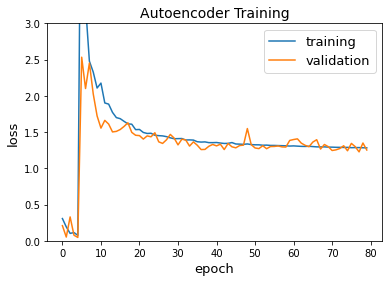

In [26]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.ylim(0,3)
plt.show()

## Data reconstructions

In [9]:
from pytorch_pae.data_loader import *

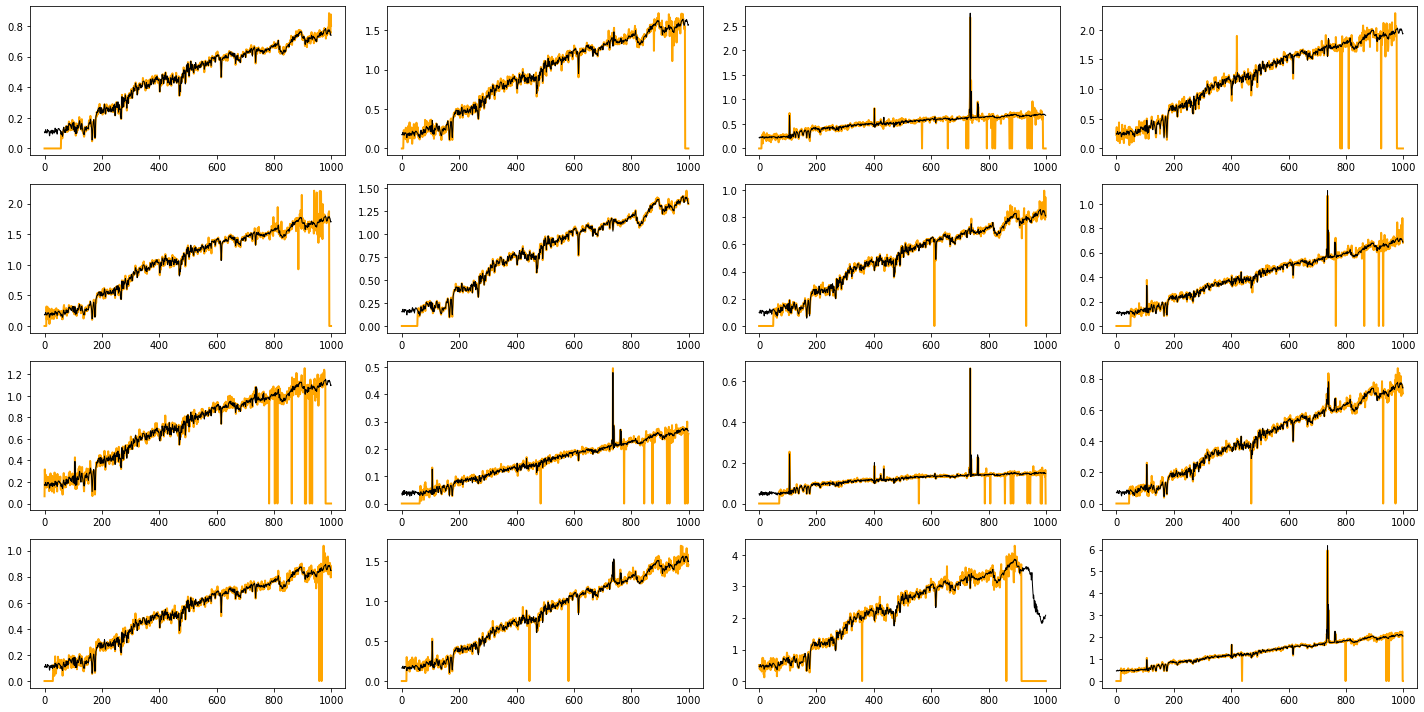

In [28]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],16, 16)

data  = next(iter(train_loader))
with torch.no_grad():
    recon = AE1.forward(data['features'].to(device).float())

fig, ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data['features'][ii].cpu().detach().numpy()),lw=2, color='orange')
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()),lw=1,color='black')
    
plt.tight_layout()
plt.show()



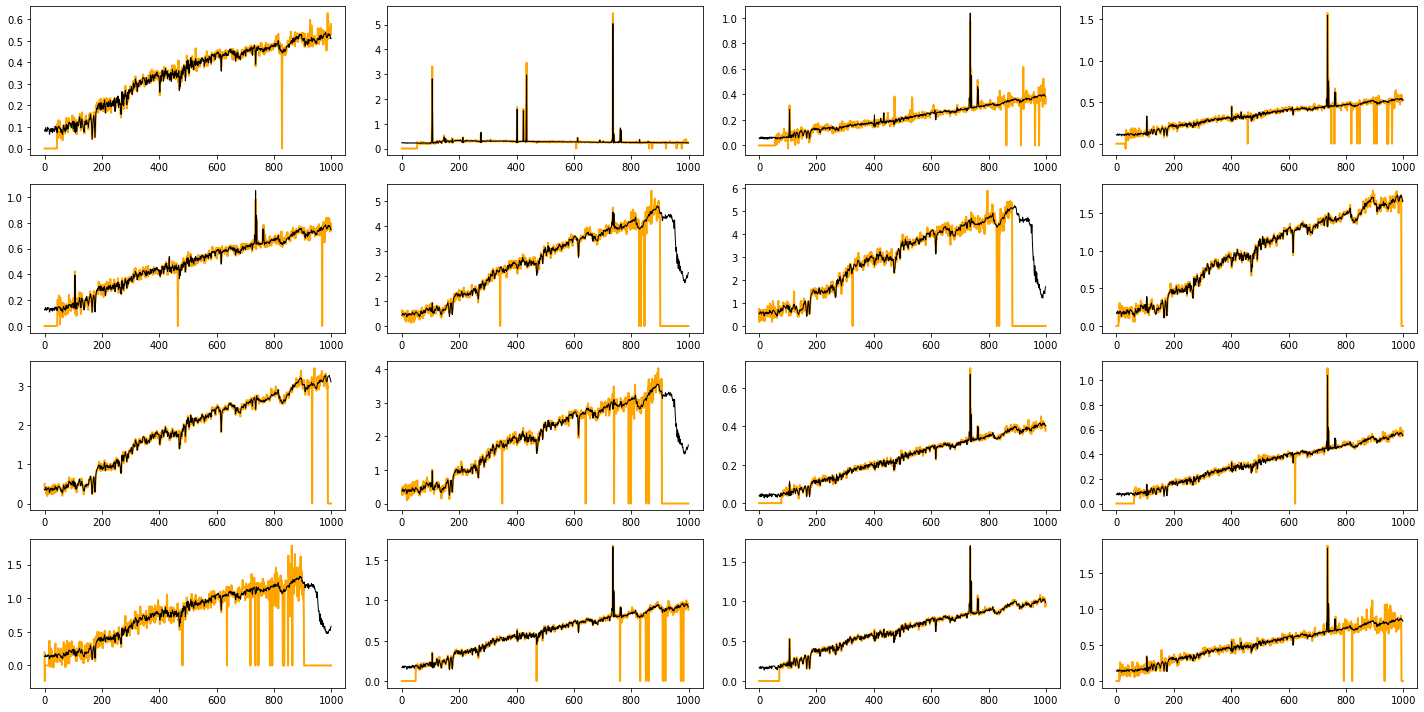

In [29]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],16, 16)

data  = next(iter(valid_loader))
with torch.no_grad():
    recon = AE1.forward(data['features'].to(device).float())

fig, ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data['features'][ii].cpu().detach().numpy()),lw=2, color='orange')
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()),lw=1,color='black')
    
plt.tight_layout()
plt.show()

In [30]:
torch.save(AE1, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE_SDSS_1'))

In [10]:
AE1 = torch.load(os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE_SDSS_1'))

In [11]:
AE1 = AE1.to('cpu')

In [41]:
def loss_by_wl(y_true, y_pred, device):
    loss           = (y_true['features'].to(device).float()-y_pred)**2*y_true['noise'].to(device).float()*y_true['mask'].to(device).float()
    valid_loss     = np.mean(loss.detach().cpu().numpy(),axis=0)
    std_valid_loss = np.std(loss.detach().cpu().numpy(),axis=0)
    return valid_loss, std_valid_loss

In [12]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1)

data_train  = next(iter(train_loader))
data_valid  = next(iter(valid_loader))

In [13]:
with torch.no_grad():
    recon_valid = AE1.forward(data_valid['features'].float())
    recon_train = AE1.forward(data_train['features'].float())

In [16]:
recon_train

tensor([[[0.5844, 0.5813, 0.5793,  ..., 1.2786, 1.3167, 1.3652]],

        [[0.0931, 0.0864, 0.0878,  ..., 0.2559, 0.2539, 0.2531]],

        [[0.2241, 0.2152, 0.2220,  ..., 1.8631, 1.8376, 1.8442]],

        ...,

        [[0.2412, 0.2311, 0.2377,  ..., 1.7527, 1.7276, 1.7351]],

        [[0.0312, 0.0248, 0.0236,  ..., 0.2152, 0.2139, 0.2134]],

        [[0.3932, 0.3810, 0.3944,  ..., 3.6586, 3.5699, 3.4626]]])

In [14]:
root_encoded     = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded     = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'



np.save(os.path.join(root_decoded,'decoded_%s_conv.npy'%(label_2)),[recon_train.numpy(), recon_valid.numpy()])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [15]:
recon_valid.shape, recon_train.shape

(torch.Size([69820, 1, 1000]), torch.Size([209462, 1, 1000]))

In [18]:
recon_error = loss_by_wl(data_valid, recon, device='cpu')

NameError: name 'loss_by_wl' is not defined

In [43]:
wlmin, wlmax    = (3388,8318)
wl_range        = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl          = np.logspace(wl_range[0],wl_range[1],input_dim)

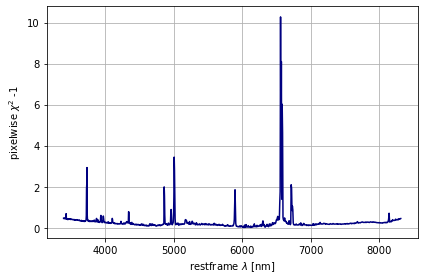

In [47]:
plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'
plt.plot(new_wl,np.squeeze(recon_error[0]/np.mean(data_valid['mask'].detach().cpu().numpy(),axis=0)-1),color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()
#plt.ylim(0,2.5)
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_convAE1.pdf'), bbox_inches='tight')

In [26]:
with torch.no_grad():
    #encoded_train = AE1.encoder.forward(data_train['features'].float()).numpy()
    encoded_valid = AE1.encoder.forward(data_valid['features'].float()).numpy()

In [27]:

np.save(os.path.join(root_encoded,'encoded_%s_conv.npy'%(label_2)),[encoded_train, encoded_valid])

/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


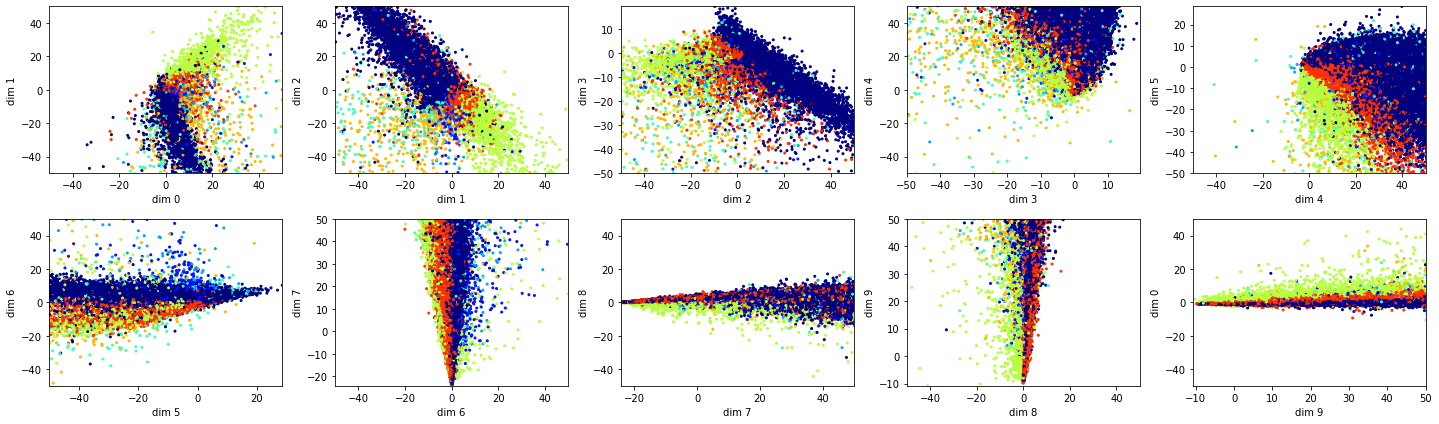

In [50]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=data['subclass'], cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    #plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_subclass_convAE1.pdf'), bbox_inches='tight')
plt.show()

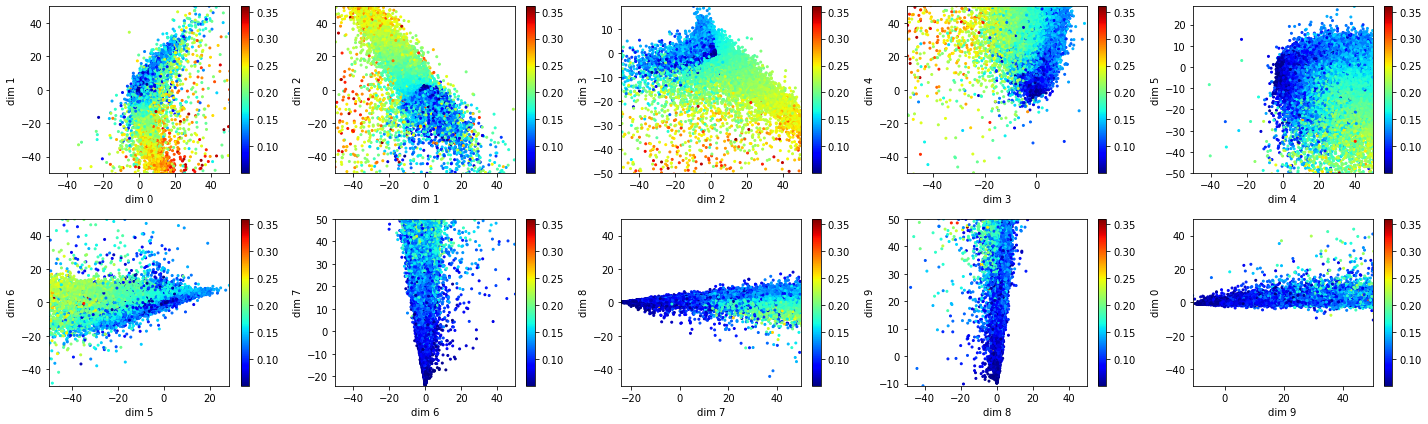

In [51]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=data['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_valid_redshift_convAE1.pdf'), bbox_inches='tight')
plt.show()

In [53]:
recon.shape, encoded_valid.shape

(torch.Size([69820, 1, 1000]), (69820, 10))